In [170]:
%matplotlib inline

In [171]:
import seaborn as sns

In [172]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold,CategoricalStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import sys
from sklearn import linear_model
import matplotlib.pyplot as plt

In [173]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.dev1.1.


In [174]:
module_path = os.path.abspath(os.path.join('..'))
print module_path
if module_path not in sys.path:
    sys.path.append(module_path)
    

/home/botty/Documents/CCFD


In [175]:
from ccfd_dnn.utils import get_engine

In [176]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

In [177]:
# load dataset
table = "data_fraud_little"
engine = get_engine()
dataframe = pd.read_sql_query("select * from {table} limit 100000".format(table=table),engine)
dataset = dataframe.values
print("First one row of the dataset")
print("Shape [{}]".format(dataset.shape))
print(dataset[0:2,:])
# split into input (X) and output (Y) variables
data_dimensions = 45
#first dimension is the index, must be removed!!!!
X = dataset[:, 1:data_dimensions]
Y = dataset[:, data_dimensions]

print("Fraud {}% ".format(float(np.sum(Y==1))*100.0/Y.shape[0]))
print("Total #samples:",Y.shape[0])
Y = to_categorical(Y, nb_classes=None)


input_dimensions = X.shape[1]
print("shapes: X[{}]=====Y[{}]".format(X.shape, Y.shape))

First one row of the dataset
Shape [(100000, 47)]
[[  4.75200320e+07   7.49524000e+05   1.38868315e+18   6.89620000e+04
    5.83500000e+01   1.77484800e+06   5.77500000e+04   1.87362000e+05
    3.67000000e+02   1.62381800e+06   1.68885100e+06   5.20000000e+02
    5.00000000e+00   0.00000000e+00   0.00000000e+00   8.00000000e+00
    1.00000000e+00   0.00000000e+00   4.00000000e+00   0.00000000e+00
    1.00000000e+00   1.00000000e+02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   5.60000000e+01   1.00000000e+00   1.00000000e+00
    0.00000000e+00   1.00000000e+00   3.00000000e+00   0.00000000e+00
    1.90000000e+01   1.84000000e+03   8.26000000e+02   6.10000000e+07
    5.83500000e+01   5.13265000e+03   7.50000000e+03   7.50000000e+03
    2.18985000e+03  -9.22337204e+18   1.38602880e+18   1.47048000e+03
    1.37419200e+18   0.00000000e+00  -9.22337204e+18]
 [  3.88424760e+07   6.72120000e+05   1.39431354e+18   1.00165000e+05
    1.49900000e+01   4.20536000e+05   1.32586000e+05   0

In [199]:
dataset.shape

(100000, 47)

In [178]:
# define base mode
def baseline_model():
    return logistic_regresion()
    # return linear_regression()


def keras_lin_reg():
    x = Input((None,input_dimensions))
    y = Dense(1,activation='linear')(x)
    model = Model(x,y,"Linear Regression")
    model.compile(loss='mse', optimizer='sgd')
    return model

def logistic_regresion():
    logistic = linear_model.LogisticRegression(solver='sag', n_jobs=-1,max_iter=500)
    return logistic
def linear_regression():
    lr = linear_model.LinearRegression(n_jobs=-1)
    return lr

def mlp_model(hidden=100,layers=1):
    # create model
    model = Sequential()
    model.add(Dense(input_dimensions, input_dim=input_dimensions, init='normal', activation='relu'))
    if hidden is not None:
        for l in range(layers):
            model.add(Dense(hidden))
    model.add(Dense(2, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def mlp_model_wrap(hidden=100,layers=1):
    return mlp_model(hidden,layers)
# fix random seed for reproducibility

In [169]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn=mlp_model, nb_epoch=100, batch_size=10000, verbose=1)))
estimators.append(('mlp', KerasClassifier(build_fn=mlp_model_wrap, nb_epoch=100, batch_size=10000, verbose=0)))
# estimators.append(('liner reg', KerasClassifier(build_fn=keras_lin_reg, nb_epoch=100, batch_size=100000, verbose=1)))
# estimators.append(('linear_reg', baseline_model()))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
print("Results:", results)
print("Results: %.24f (%.24f) ROC" % (results.mean(), results.std()))
print(pipeline)

NameError: name 'X' is not defined

In [179]:
seed = 7
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))

estimators.append(('mlp', KerasClassifier(build_fn=mlp_model_wrap, batch_size=5000, verbose=0)))

pipeline = Pipeline(estimators)#
pipeline.set_params(mlp__layers=1)
pipeline.set_params(mlp__hidden=100)
pipeline.set_params(mlp__nb_epoch=30)

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f06465db1d0>)])

In [180]:
print "Epochs {}@{}({}):{}".format(epoch,i,h,l)

NameError: name 'epoch' is not defined

In [ ]:
pipeline.set_params(mlp__nb_epoch=1)
pipeline.set_params(mlp__layers=19)
pipeline.set_params(mlp__hidden=1024)
pipeline.fit(X,Y)

In [163]:
import datetime as dt

In [164]:
t_start = dt.datetime.now()

In [166]:
print 'time taken: {time}'.format(time=dt.datetime.now()-t_start)

time taken: 0:01:48.965330


In [181]:
epochs = [500,1000,2000]
# epochs = [1]
layers = range(20)
# layers = range(5)
hidden_dim = [32,64,128,200,256,300,450,512,700,820,1024]
# hidden_dim = [32,64,128,200,256,]
scores_means = {}
scores_stds = {}
kfold = KFold(n_splits=3, random_state=seed)

for epoch in epochs:
    t_start = dt.datetime.now()
    scores_means[str(epoch)] = np.array([[0.0 for x in range(len(layers))] for y in range(len(hidden_dim))])
    scores_stds[str(epoch)] = np.array([[0.0 for x in range(len(layers))] for y in range(len(hidden_dim))])
    pipeline.set_params(mlp__nb_epoch=epoch)
    
    for i,h in enumerate(hidden_dim):
        pipeline.set_params(mlp__hidden=h)
        for j,l in enumerate(layers):
            pipeline.set_params(mlp__layers=l)
            this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
#             print scores_means[str(epoch)].shape
            print "Epochs {}@{}({}):{}".format(epoch,i,h,l)
            scores_means[str(epoch)][i,j] = this_scores.mean()
            scores_stds[str(epoch)][i,j] = this_scores.std()
    print 'time taken: {time}'.format(time=dt.datetime.now()-t_start)

Epochs 500@0(32):0
Epochs 500@0(32):1
Epochs 500@0(32):2
Epochs 500@0(32):3
Epochs 500@0(32):4
Epochs 500@0(32):5
Epochs 500@0(32):6
Epochs 500@0(32):7
Epochs 500@0(32):8
Epochs 500@0(32):9
Epochs 500@0(32):10
Epochs 500@0(32):11
Epochs 500@0(32):12
Epochs 500@0(32):13
Epochs 500@0(32):14
Epochs 500@0(32):15
Epochs 500@0(32):16
Epochs 500@0(32):17
Epochs 500@0(32):18
Epochs 500@0(32):19
Epochs 500@1(64):0
Epochs 500@1(64):1
Epochs 500@1(64):2
Epochs 500@1(64):3
Epochs 500@1(64):4
Epochs 500@1(64):5
Epochs 500@1(64):6
Epochs 500@1(64):7
Epochs 500@1(64):8
Epochs 500@1(64):9
Epochs 500@1(64):10
Epochs 500@1(64):11
Epochs 500@1(64):12
Epochs 500@1(64):13
Epochs 500@1(64):14
Epochs 500@1(64):15
Epochs 500@1(64):16
Epochs 500@1(64):17
Epochs 500@1(64):18
Epochs 500@1(64):19
Epochs 500@2(128):0
Epochs 500@2(128):1
Epochs 500@2(128):2
Epochs 500@2(128):3
Epochs 500@2(128):4
Epochs 500@2(128):5
Epochs 500@2(128):6
Epochs 500@2(128):7
Epochs 500@2(128):8
Epochs 500@2(128):9
Epochs 500@2(128):10

Epochs 1000@8(700):12
Epochs 1000@8(700):13
Epochs 1000@8(700):14
Epochs 1000@8(700):15
Epochs 1000@8(700):16
Epochs 1000@8(700):17
Epochs 1000@8(700):18
Epochs 1000@8(700):19
Epochs 1000@9(820):0
Epochs 1000@9(820):1
Epochs 1000@9(820):2
Epochs 1000@9(820):3
Epochs 1000@9(820):4
Epochs 1000@9(820):5
Epochs 1000@9(820):6
Epochs 1000@9(820):7
Epochs 1000@9(820):8
Epochs 1000@9(820):9
Epochs 1000@9(820):10
Epochs 1000@9(820):11
Epochs 1000@9(820):12
Epochs 1000@9(820):13
Epochs 1000@9(820):14
Epochs 1000@9(820):15
Epochs 1000@9(820):16
Epochs 1000@9(820):17
Epochs 1000@9(820):18
Epochs 1000@9(820):19
Epochs 1000@10(1024):0
Epochs 1000@10(1024):1
Epochs 1000@10(1024):2
Epochs 1000@10(1024):3
Epochs 1000@10(1024):4
Epochs 1000@10(1024):5
Epochs 1000@10(1024):6
Epochs 1000@10(1024):7
Epochs 1000@10(1024):8
Epochs 1000@10(1024):9
Epochs 1000@10(1024):10
Epochs 1000@10(1024):11
Epochs 1000@10(1024):12
Epochs 1000@10(1024):13
Epochs 1000@10(1024):14
Epochs 1000@10(1024):15
Epochs 1000@10(1024)

In [182]:
import cPickle
# save_path = "/home/botty/Documents/CCFD/results/Analysis/scores_w_vs_d.npy"
save_path = "/home/botty/Documents/CCFD/results/Analysis/scores_w_vs_d_500.npy"
np.save(save_path,scores_means)

Loading

In [189]:
%store scores_old
%store scores_means

Stored 'scores_old' (dict)
Stored 'scores_means' (dict)


In [190]:
%store -r scores_all

In [191]:
scores_dict = scores_all

In [192]:
scores_dict.keys()

['200', '30', '60', '2000', '100', '500', '1000']

In [ ]:
#scores_means = np.load(save_path)

In [184]:
scores_old = scores_dict 

In [185]:
scores_old.keys()

['60', '200', '100', '30']

In [151]:

scores_dict = dict(scores_means.tolist())

In [183]:
scores_dict.keys()

['60', '200', '100', '30']

In [59]:
tips = sns.load_dataset("tips")

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)

In [133]:
layers = map(lambda x: x+1,layers)

In [137]:
wide_deep_fig_path = "/home/botty/Documents/CCFD/results/figures/wide_deep/"

In [139]:
a = axes[c]

In [142]:
?plt.subplots

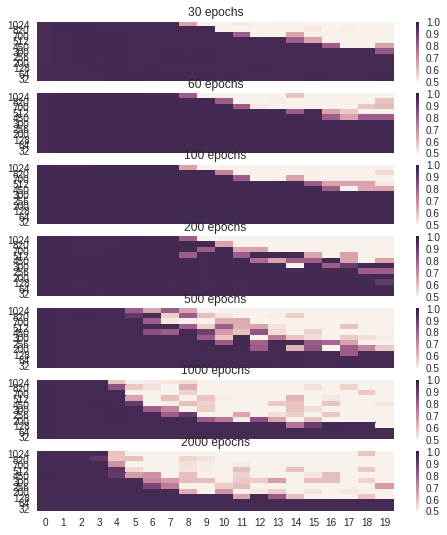

In [193]:
epochs_str = [str(x) for x in [30,60,100,200, 500, 1000, 2000]]
epochs_str = [str(x) for x in [30,60,100,200, 500, 1000, 2000]]
f, axes = plt.subplots(len(epochs_str), sharex=True, sharey=True,figsize=(8, 9))
for c,key in enumerate(epochs_str):##
#     print(scores_dict[key].shape)
#     print key
    axes[c].set_title('{} epochs'.format(key))
    sns.heatmap(scores_dict[key],ax=axes[c],xticklabels=layers,yticklabels=h_dim,vmin=0.5,vmax=1).invert_yaxis()
f.savefig(wide_deep_fig_path+"big_picture_2000")

There seems to be a significant degree of overfitting as the number of epochs drastically increase. In conjunction with the insignificant amount of samples (100,000 examples), our findings suggest that theoretical results of the expressive power of DNNs are only applicable in the presence of excessive amounts of training data. 

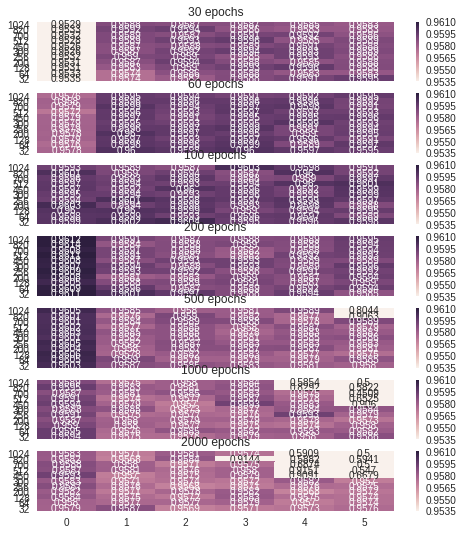

In [197]:
f, axes = plt.subplots(len(epochs_str), sharex=True, sharey=True,figsize=(8, 9))
for c,key in enumerate(epochs_str):
    axes[c].set_title('{} epochs'.format(key))
    sns.heatmap(scores_dict[key][:,0:6],ax=axes[c],vmin=0.9535,vmax=0.9610,xticklabels=layers,yticklabels=h_dim,annot=True,fmt='.4g').invert_yaxis()

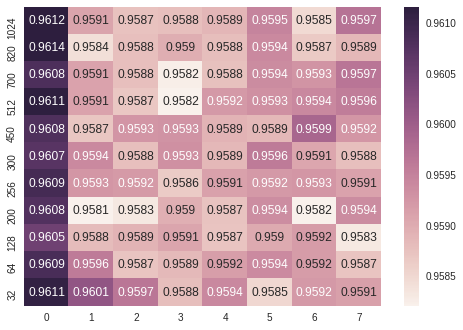

In [116]:
sns.heatmap(scores_dict['200'][:,0:8],robust=True,annot=True,fmt='.4g',xticklabels=layers,yticklabels=h_dim).invert_yaxis()

In [154]:
scores_dict['200'].max(axis=1)

array([ 0.96108864,  0.96085797,  0.96047991,  0.96077981,  0.96091118,
        0.96071132,  0.9608069 ,  0.96113484,  0.96081607,  0.96139458,
        0.9612226 ])

In [198]:
scores_dict['500'].max(axis=1)

array([ 0.96030137,  0.96052197,  0.96064048,  0.9603713 ,  0.96049163,
        0.96010414,  0.96025914,  0.96021885,  0.9601452 ,  0.96012237,
        0.96046914])

In [201]:
scores_dict['500'].max()

0.96064048450000283

In [202]:
scores_dict['1000'].max()

0.95945102320957432

In [203]:
scores_dict['2000'].max()

0.95925128559459194

## Maximum AUC and index


In [204]:
for c,key in enumerate(epochs_str):
    arr = scores_dict[key]
    idx = np.unravel_index(arr.argmax(),arr.shape)
    print arr.max(), "dimensions", h_dim[idx[0]],"layers",layers[idx[1]]

0.9595728114 dimensions 128 layers 4
0.960244627287 dimensions 128 layers 14
0.960436414725 dimensions 450 layers 11
0.961394577674 dimensions 820 layers 0
0.9606404845 dimensions 128 layers 0
0.95945102321 dimensions 64 layers 0
0.959251285595 dimensions 450 layers 0


In [207]:
for c,key in enumerate(["500","1000","2000"]):
    arr = scores_stds[key]
    idx = np.unravel_index(arr.argmax(),arr.shape)
    print arr.max(), "dimensions", h_dim[idx[0]],"layers",layers[idx[1]]

0.335095946552 dimensions 200 layers 18
0.288481726286 dimensions 128 layers 14
0.232971568868 dimensions 256 layers 16


In [208]:
for c,key in enumerate(["500","1000","2000"]):
    arr = scores_stds[key]
    idx = np.unravel_index(arr.argmin(),arr.shape)
    print arr.min(), "dimensions", h_dim[idx[0]],"layers",layers[idx[1]]

0.0 dimensions 450 layers 17
0.0 dimensions 300 layers 8
0.0 dimensions 200 layers 11


In [ ]:
num_h_itr = len(hidden_dim)
num_h_itr = 6
num_l_itr = len(layers)
pairs = zip(range(num_h_itr), range(num_l_itr))

for epoch in epochs:
    print epoch
    for h, l in pairs:
        print "Epochs {}@{}:{}".format(epoch,hidden_dim[h],layers[l])
        fig, ax1 = plt.subplots()
#         ax.errorbar(layers, scores_means[str(epoch)][h,:], np.array(scores_stds[str(epoch)][h,:]))
#         ax.errorbar(hidden_dim, scores_means[str(epoch)][:,l], np.array(scores_stds[str(epoch)][:,l]))

        color_layers = 'darkorange'
        ax1.errorbar(layers[0:num_l_itr], scores_means[str(epoch)][h,0:num_l_itr], np.array(scores_stds[str(epoch)][h,0:num_l_itr]),color=color_layers)
        # Make the y-axis label, ticks and tick labels match the line color.
        ax1.set_xlabel('depth', color=color_layers)
        ax1.tick_params('x', colors=color_layers)

        ax2 = ax1.twiny()
        ax2.errorbar(hidden_dim[0:num_h_itr], scores_means[str(epoch)][0:num_h_itr,l], np.array(scores_stds[str(epoch)][0:num_h_itr,l]))
        ax2.set_xlabel('width',color='royalblue')
        ax2.tick_params('x', colors='royalblue')
        ax2.set_ylabel('AUC')
        fig.tight_layout()
        plt.show()
        
    break

In [ ]:
test_m = np.array([[1,2,3],[4,5,6]])
max(test_m)

In [ ]:
scores_means

In [ ]:
for matrix in scores_means:
    print matrix
    print max(scores_means[matrix].flatten())
    print min(scores_means[matrix].flatten())

In [ ]:
num_h_itr = len(hidden_dim)
# num_h_itr = 6
num_l_itr = len(layers)
pairs = zip(range(num_h_itr), range(num_l_itr))

for epoch in epochs:
    print epoch
    for h, l in pairs:
        print "Epochs {}@{}:{}".format(epoch,hidden_dim[h],layers[l])       
        ymin = 0.95
        ymax = 0.965
        fig, ax1 = plt.subplots()
#         ax.errorbar(layers, scores_means[str(epoch)][h,:], np.array(scores_stds[str(epoch)][h,:]))
#         ax.errorbar(hidden_dim, scores_means[str(epoch)][:,l], np.array(scores_stds[str(epoch)][:,l]))

        color_layers = 'darkorange'
        ax1.errorbar(layers[0:num_l_itr], scores_means[str(epoch)][h,0:num_l_itr], np.array(scores_stds[str(epoch)][h,0:num_l_itr]),color=color_layers)
        # Make the y-axis label, ticks and tick labels match the line color.
        ax1.set_xlabel('depth', color=color_layers)
        ax1.tick_params('x', colors=color_layers)
        l_p = layers[l]
        ax1.plot((l_p,l_p),(0,1),color=color_layers,linestyle='dashed')
#         ax1.set_ylim([ymin,ymax])
        ax2 = ax1.twiny()
        ax2.errorbar(hidden_dim[0:num_h_itr], scores_means[str(epoch)][0:num_h_itr,l], np.array(scores_stds[str(epoch)][0:num_h_itr,l]))
        ax2.set_xlabel('width',color='royalblue')
        ax2.tick_params('x', colors='royalblue')
        ax2.set_ylabel('AUC')
        h_p = hidden_dim[h]
        ax2.plot((h_p,h_p),(0,1),color='royalblue',linestyle='dashed')
        ax2.set_ylim([ymin,ymax])
        fig.tight_layout()
        plt.show()
        print h_p,l_p
        print h,l
        h_n = hidden_dim.index(h_p)
        l_n = layers.index(l_p)
        print scores_means[str(epoch)][h_n,l_n]
        h_n = hidden_dim.index(128)
        l_n = layers.index(5)
        print h_n,l_n
        print scores_means[str(epoch)][h_n,l_n]
       

In [ ]:
print_score(128,5)
print_c_score(5,5)
print_score(300,5)

In [ ]:
def print_score(h,l,epoch='30'):
    print h,l
    h_n = hidden_dim.index(h)
    l_n = layers.index(l)
    print_c_score(h_n,l_n,epoch)

In [ ]:
def print_c_score(h_n,l_n,epoch='30'):
    print h_n,l_n
    print scores_means[str(epoch)][h_n,l_n]

In [ ]:
a = w, h = 8, 5;
Matrix = [[0 for x in range(w)] for y in range(h)] ,nrows=max(len(hidden_dim),len(layers)

In [ ]:
[25 * (x+ for x in range(2,20)]

In [ ]:
mlp_model_wrap.__call__

In [ ]:
score_means_l = list()
score_stds_l = list()
layers = range(20)
kfold = KFold(n_splits=3, random_state=seed)
for l in layers:
    pipeline.set_params(mlp__layers=l) 
    this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    score_means_l.append(this_scores.mean())
    score_stds_l.append(this_scores.std())

title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers, score_means_l, np.array(score_stds_l))
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [ ]:
score_means_l = list()
score_stds_l = list()
layers = range(20)
kfold = KFold(n_splits=3, random_state=seed)
pipeline.set_params(mlp__nb_epoch=100)
for l in layers:
    pipeline.set_params(mlp__layers=l) 
    this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    score_means_l.append(this_scores.mean())
    score_stds_l.append(this_scores.std())

title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers, score_means_l, np.array(score_stds_l))
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [ ]:
len(score_means_l)

In [ ]:
title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers[0:9], score_means_l, np.array(score_stds_l))
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [ ]:
layers = range(20)
score_means = range(20)
score_stds = range(20)



title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers, score_means, np.array(score_stds))
hold on;
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [ ]:
score_means = list()
score_stds = list()
layers = [50,75,100,125,150,200,400,800,1000,2000]
kfold = KFold(n_splits=3, random_state=seed)
for l in layers:
    pipeline.set_params(mlp__hidden=l) 
    this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
title = "Performance of the MLP with Increasing Hidden Layer Sizes"
fig = plt.figure()
plt.errorbar(layers, score_means, np.array(score_stds))
plt.title(title)
plt.xlabel('Number of neurons')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [ ]:
##TODO
layers = range(20)
title = "Depth vs Width"
fig = plt.figure()
plt.errorbar(layers, score_means_l, np.array(score_stds_l))
# layers = [50,75,100,125,150,200,400,800,1000,2000]
layers = range(10)
plt.errorbar(layers, score_means, np.array(score_stds))
plt.title(title)
plt.xlabel('Number of neurons')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [ ]:
score_means

In [ ]:
pipeline.fit(X,Y)

In [ ]:
y_pred = pipeline.predict_proba(X)

In [ ]:
y_pred[0:50,:]

In [ ]:
target_names = ["Genuine", "Fraud"]
y_test = Y
fpr,tpr,tresholds = roc_curve(y_test[:,0],y_pred[:,0])
print(auc(fpr, tpr))
# print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [ ]:
fpr,tpr

In [ ]:
input_dimensions

### Logistic Regression


In [9]:
print X.shape
print Y.shape
print Y[:,0]

(100000, 44)
(100000, 2)
[ 1.  1.  0. ...,  1.  1.  1.]


In [10]:
X_sub = X[:1000,:]
Y_sub = Y[:1000]
X_sub.shape[1]

44

In [11]:
def logistic_regresion():
    logistic = linear_model.LogisticRegression(solver='sag', n_jobs=5, max_iter=500)
    return logistic

In [12]:
def keras_lin_reg(input_dimensions):
    y = Dense(1, init='normal', activation='linear',input_shape=(input_dimensions,))
    model = Sequential([y], "Linear Regression")
    model.compile(loss='mse', optimizer='sgd')
    return model

In [13]:
def keras_log_reg(input_dimensions):
    y = Dense(2, init='normal', activation='softmax',input_shape=(input_dimensions,))
    # Compile model
#     from IPython.core.debugger import Tracer;Tracer()()
    model = Sequential([y], "Logistic Regression")
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [14]:
def keras_mlp_model(input_dimensions,hidden=100,layers=1):
    # create model
    model = Sequential()
    model.add(Dense(hidden, input_dim=input_dimensions, init='normal', activation='relu'))
    if hidden is not None:
        for l in range(layers):
            model.add(Dense(hidden))
    model.add(Dense(2, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [15]:
def compare(models,X,Y,scale=True,cv=5):
    """Compares different sk-learn models
    
    Parameters
        ----------
    models : dict
        model object, expected ouotput dimensions
    """
    seed = 7
    np.random.seed(seed)
    results = {}
    for m in models.keys():
        
        estimators = []
        if scale:
            estimators.append(('standardize', StandardScaler()))
        estimators.append(m)
        pipeline = Pipeline(estimators)
#         kfold = CategoricalStratifiedKFold(n_splits=5, random_state=seed)
        ## set model output dimensioanlity
        Y_shaped = Y[:] if models[m] == None else Y[:,models[m]]
        if Y_shaped.shape[1] > 1:
            kfold = CategoricalStratifiedKFold(n_splits=5, random_state=seed) 
        else:
            kfold = StratifiedKFold(n_splits=5, random_state=seed)
#         from IPython.core.debugger import Tracer; Tracer()()
#         if cv is None:
        
#             results[m] = pipeline, X, Y_shaped, cv=kfold, scoring='roc_auc',n_jobs=1)
#             fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_shaped)
#             auc_val = auc(fpr, tpr)
        results[m] = cross_val_score(pipeline, X, Y_shaped, cv=kfold, scoring='roc_auc',n_jobs=1)
    return results



In [16]:
def compare_report(results):
    n = max([len(x[0]) for x in results.keys()])
    for m in results.keys():
        print("%*s %.4f %.4f" % (n,m[0],results[m].mean(),results[m].std()))

In [16]:
[x[0] for x in results.keys()]

NameError: name 'results' is not defined

In [ ]:
m = results.keys()[0]
n = 15
print("%*s %.4f %.4f" % (n,m[0],results[m].mean(),results[m].std()))

In [ ]:
nb_epochs = 1
m1 = ('log_reg',KerasClassifier(build_fn=keras_log_reg,input_dimensions=X_sub.shape[1], nb_epoch=nb_epochs, batch_size=10000, verbose=0))
m2 = ('log_reg_sk_learn',logistic_regresion())
m3 = ('lin_reg',KerasClassifier(build_fn=keras_lin_reg,input_dimensions=X_sub.shape[1], nb_epoch=nb_epochs, batch_size=10000, verbose=0))
m4 = ('lin_reg',KerasClassifier(build_fn=keras_mlp_model,input_dimensions=X_sub.shape[1], hidden=100,layers=1, nb_epoch=nb_epochs, batch_size=10000, verbose=0))
m5 = ('lin_reg',KerasClassifier(build_fn=keras_mlp_model,input_dimensions=X_sub.shape[1], hidden=100,layers=2, nb_epoch=nb_epochs, batch_size=10000, verbose=0))
results = compare({m1:None,m2:0,m3:0,m4:None,m5:None},X_sub,Y_sub)
compare_report(results)

In [ ]:
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    # estimators.append(('mlp', KerasClassifier(build_fn=mlp_model, nb_epoch=100, batch_size=10000, verbose=1)))
    estimators.append(('log_reg', KerasClassifier(build_fn=mlp_model_wrap, nb_epoch=100, batch_size=10000, verbose=0)))
    # estimators.append(('liner reg', KerasClassifier(build_fn=keras_lin_reg, nb_epoch=100, batch_size=100000, verbose=1)))
    # estimators.append(('linear_reg', baseline_model()))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    print("Results:", results)
    print("Results: %.24f (%.24f) ROC" % (results.mean(), results.std()))

In [17]:
def load_dataset(table,rm_unavail=False, lim = ''):
    # load dataset
    engine = get_engine()
    dataframe = pd.read_sql_query("select * from {table} {lim}".format(table=table,lim=lim),engine)
    data_dimensions = 45
    if rm_unavail:
        unav_cols = ['AUTHZN_APPRL_CD','TSYS_DCLN_REAS_CD','AUTHZN_RESPNS_CD','AUTHZN_APPRD_AMT',]
        unav_cols = [x.lower() for x in unav_cols]
        for col in unav_cols:
            dataframe.drop([col], axis = 1, inplace = True)
            data_dimensions-=1
#     print("Columns: "+dataframe.columns)
    dataset = dataframe.values
#     print("First one row of the dataset")
    print("Shape [{}]".format(dataset.shape))
#     print(dataset[0:2,:])
    # split into input (X) and output (Y) variables
    
    #first dimension is the index, must be removed!!!!
    X = dataset[:, 1:data_dimensions]
    Y = dataset[:, data_dimensions]

    print("Fraud {}% ".format(float(np.sum(Y==1))*100.0/Y.shape[0]))
    print("Total #samples:",Y.shape[0])
    Y = to_categorical(Y, nb_classes=None)


    input_dimensions = X.shape[1]
    print("shapes: X[{}]=====Y[{}]".format(X.shape, Y.shape))
    return X,Y

In [23]:
%%time

table = "data_fraud"
load_dataset(table,rm_unavail=True)

KeyboardInterrupt: 

In [24]:
tables = ["data_little_enc", "data_fraud_little"]
data_sets = []
for t in tables:
    data_sets.append(load_dataset(t))

for ds in data_sets:
    X_sub,Y_sub = ds
    print X_sub.shape
    print Y_sub.shape
    nb_epochs = 50
    m1 = ('log_reg',KerasClassifier(build_fn=keras_log_reg,input_dimensions=X_sub.shape[1], nb_epoch=nb_epochs, batch_size=10000, verbose=0))
    m2 = ('log_reg_sk_learn',logistic_regresion())
    m3 = ('lin_reg',KerasClassifier(build_fn=keras_lin_reg,input_dimensions=X_sub.shape[1], nb_epoch=nb_epochs, batch_size=10000, verbose=0))
    m4 = ('mlp_2',KerasClassifier(build_fn=keras_mlp_model,input_dimensions=X_sub.shape[1], hidden=100,layers=1, nb_epoch=nb_epochs, batch_size=10000, verbose=0))
    m5 = ('mlp_3',KerasClassifier(build_fn=keras_mlp_model,input_dimensions=X_sub.shape[1], hidden=100,layers=2, nb_epoch=nb_epochs, batch_size=10000, verbose=0))
    results = compare({m1:None,m4:None,m5:None},X_sub,Y_sub)
    compare_report(results)


Shape [(500000, 47)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 44)]=====Y[(500000, 2)]
Shape [(600000, 47)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 44)]=====Y[(600000, 2)]
(500000, 44)
(500000, 2)


KeyboardInterrupt: 

## Experiment set-up

In [29]:
from ccfd_dnn.utils import *

In [30]:
limit = 5e3
lim = 'limit {}'.format(limit)
lim = ''

In [31]:
tables = ["data_little_enc", "data_fraud_little"]

In [32]:
def run_experiment(tables,scale,rm_unavail,lim,nb_epochs = 50):

    data_sets = []
    t_start = dt.datetime.now()
    for t in tables:
        data_sets.append(load_dataset(t,lim=lim, rm_unavail=rm_unavail))
    print 'time taken: {time}'.format(time=days_hours_minutes_seconds(dt.datetime.now()-t_start))
    for ds in data_sets:
        X_sub,Y_sub = ds
        print X_sub.shape
        print Y_sub.shape
        print X_sub.dtype, Y_sub.dtype
        m1 = ('log_reg',KerasClassifier(build_fn=keras_log_reg,input_dimensions=X_sub.shape[1], nb_epoch=nb_epochs, batch_size=10000, verbose=0))
        m4 = ('mlp_2',KerasClassifier(build_fn=keras_mlp_model,input_dimensions=X_sub.shape[1], hidden=100,layers=1, nb_epoch=nb_epochs, batch_size=10000, verbose=0))
        m5 = ('mlp_3',KerasClassifier(build_fn=keras_mlp_model,input_dimensions=X_sub.shape[1], hidden=100,layers=2, nb_epoch=nb_epochs, batch_size=10000, verbose=0))
        results = compare({m1:None,m4:None,m5:None},X_sub,Y_sub,scale=scale)
        compare_report(results)
    print 'time taken: {time}'.format(time=days_hours_minutes_seconds(dt.datetime.now()-t_start))

### No scaling


In [34]:
scale = False
rm_unav = False

In [35]:
run_experiment(tables,scale,rm_unav,lim,nb_epochs=50)

Shape [(500000, 47)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 44)]=====Y[(500000, 2)]
Shape [(600000, 47)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 44)]=====Y[(600000, 2)]
time taken: (0, 0, 1, 7)
(500000, 44)
(500000, 2)
float64 float64
  mlp_3 0.4937 0.0125
log_reg 0.4827 0.0108
  mlp_2 0.5019 0.0155
(600000, 44)
(600000, 2)
float64 float64
log_reg 0.5014 0.0148
  mlp_3 0.5078 0.0119
  mlp_2 0.5057 0.0061
time taken: (0, 0, 30, 43)


In [36]:
run_experiment(tables,scale,rm_unav,lim,nb_epochs=100)

Shape [(500000, 47)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 44)]=====Y[(500000, 2)]
Shape [(600000, 47)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 44)]=====Y[(600000, 2)]
time taken: (0, 0, 1, 4)
(500000, 44)
(500000, 2)
float64 float64
log_reg 0.5064 0.0445
  mlp_2 0.5414 0.0417
  mlp_3 0.4999 0.0014
(600000, 44)
(600000, 2)
float64 float64
log_reg 0.4946 0.0142
  mlp_3 0.5090 0.0262
  mlp_2 0.5046 0.0068
time taken: (0, 0, 58, 50)


In [37]:
run_experiment(tables,scale,rm_unav,lim,nb_epochs=200)

Shape [(500000, 47)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 44)]=====Y[(500000, 2)]
Shape [(600000, 47)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 44)]=====Y[(600000, 2)]
time taken: (0, 0, 1, 1)
(500000, 44)
(500000, 2)
float64 float64
log_reg 0.5247 0.0497
  mlp_2 0.5015 0.0273
  mlp_3 0.5056 0.0640
(600000, 44)
(600000, 2)
float64 float64
log_reg 0.4948 0.0136
  mlp_3 0.5030 0.0059
  mlp_2 0.4825 0.0130
time taken: (0, 1, 57, 24)


In [46]:
np.where(Y_sub[:,1] == 0)[0].shape

(848,)

### Remove unvailable columns 
does not sound possible to shift as datapoints are scrambled

In [ ]:
#TODO

In [38]:
scale = False
rm_unav = True
run_experiment(tables,scale,rm_unav,lim,nb_epochs=50)

Shape [(500000, 43)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 40)]=====Y[(500000, 2)]
Shape [(600000, 43)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 40)]=====Y[(600000, 2)]
time taken: (0, 0, 1, 7)
(500000, 40)
(500000, 2)
float64 float64
log_reg 0.4935 0.0227
  mlp_3 0.4753 0.0455
  mlp_2 0.4988 0.0709
(600000, 40)
(600000, 2)
float64 float64
log_reg 0.5022 0.0122
  mlp_3 0.5060 0.0155
  mlp_2 0.4942 0.0073
time taken: (0, 0, 31, 20)


In [39]:
run_experiment(tables,scale,rm_unav,lim,nb_epochs=100)

Shape [(500000, 43)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 40)]=====Y[(500000, 2)]
Shape [(600000, 43)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 40)]=====Y[(600000, 2)]
time taken: (0, 0, 1, 6)
(500000, 40)
(500000, 2)
float64 float64
  mlp_3 0.5097 0.0350
  mlp_2 0.5392 0.0603
log_reg 0.4949 0.0709
(600000, 40)
(600000, 2)
float64 float64
log_reg 0.5080 0.0192
  mlp_3 0.4995 0.0094
  mlp_2 0.5021 0.0125
time taken: (0, 1, 0, 5)


In [40]:
run_experiment(tables,scale,rm_unav,lim,nb_epochs=200)

Shape [(500000, 43)]
Fraud 0.13% 
('Total #samples:', 500000)
shapes: X[(500000, 40)]=====Y[(500000, 2)]
Shape [(600000, 43)]
Fraud 16.6666666667% 
('Total #samples:', 600000)
shapes: X[(600000, 40)]=====Y[(600000, 2)]
time taken: (0, 0, 1, 7)
(500000, 40)
(500000, 2)
float64 float64
log_reg 0.4872 0.0168
  mlp_3 0.5345 0.0493
  mlp_2 0.5541 0.0462
(600000, 40)
(600000, 2)
float64 float64
  mlp_2 0.4970 0.0129
log_reg 0.5023 0.0067
  mlp_3 0.5068 0.0147
time taken: (0, 1, 58, 27)


In [ ]:
dataframe.columns

In [ ]:
df.drop(['index'],inplace=True,axis=1)

In [411]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### or shift?
does not sound possible to shift as datapoints are scrambled

In [ ]:
df.groupby('acct_id').count().mean()

### Time only

In [22]:
def reshape_time(raw_data,seq_len=100):
    tran_num = raw_data.shape[0]
    feat_num = raw_data.shape[1]
    seq_num = tran_num/seq_len
    reshaped_data = raw_data.reshape((seq_num,seq_len,feat_num))
    return reshaped_data
    

In [23]:
def load_dataset_time(table,lim=1e4):
    # load dataset
    engine = get_engine()
    dataframe = pd.read_sql_query("select * from {table} limit {lim}".format(table=table,lim=lim),engine)
    dataset = dataframe.sort_values(['authzn_rqst_proc_tm'], ascending=[1]).values

    print("Shape [{}]".format(dataset.shape))

    # split into input (X) and output (Y) variables
    data_dimensions = 45
    #first dimension is the index, must be removed!!!!
    X = dataset[:, 1:data_dimensions]
    Y = dataset[:, data_dimensions]

    print("Fraud {}% ".format(float(np.sum(Y==1))*100.0/Y.shape[0]))
    print("Total #samples:",Y.shape[0])
    Y = to_categorical(Y, nb_classes=None)


    input_dimensions = X.shape[1]
    print("prior shapes: X[{}]=====Y[{}]".format(X.shape, Y.shape))
    X = reshape_time(X)
    Y = reshape_time(Y)
    print("converted shapes: X[{}]=====Y[{}]".format(X.shape, Y.shape))
    return X,Y

In [34]:
tables = ["data_fraud_little"]
data_sets = []
for t in tables:
    data_sets.append(load_dataset_time(t))

Shape [(10000, 47)]
Fraud 16.4% 
('Total #samples:', 10000)
prior shapes: X[(10000, 44)]=====Y[(10000, 2)]
converted shapes: X[(100, 100, 44)]=====Y[(100, 100, 2)]


In [35]:
raw_data = df.sort_values(['authzn_rqst_proc_tm'], ascending=[1]).values

NameError: name 'df' is not defined

In [24]:
from keras.layers import TimeDistributed
from keras.layers.recurrent import SimpleRNN

In [209]:
def keras_rnn_model(input_dimensions,seq_len,hidden=100,layers=1,unit=SimpleRNN):
    # create model
    model = Sequential()
    model.add(unit(hidden, input_shape=(seq_len,input_dimensions), init='normal', activation='relu',return_sequences=True))
    if hidden is not None:
        for l in range(layers):
            model.add(unit(hidden, init='normal', activation='relu',return_sequences=True))
    model.add(TimeDistributed(Dense(2, init='normal', activation='softmax')))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return model

In [27]:
tables = ["data_fraud_little"]
data_sets = []
for t in tables:
    data_sets.append(load_dataset_time(t))

for ds in data_sets:
    X_sub,Y_sub = ds
    print X_sub.shape
    print Y_sub.shape
    nb_epochs = 1
    batch_size = 1e4/ X_sub.shape[1]
    m5 = ('rnn',KerasClassifier(build_fn=keras_rnn_model,input_dimensions=X_sub.shape[2],seq_len=X_sub.shape[1],hidden=100,layers=2, nb_epoch=nb_epochs, batch_size=batch_size, verbose=0))
    results = compare({m5:None},X_sub,Y_sub,scale=False)
    compare_report(results)

Shape [(10000, 47)]
Fraud 16.4% 
('Total #samples:', 10000)
prior shapes: X[(10000, 44)]=====Y[(10000, 2)]
converted shapes: X[(100, 100, 44)]=====Y[(100, 100, 2)]
(100, 100, 44)
(100, 100, 2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
%store ds 

Stored 'ds' (tuple)


In [423]:
raw_data.shape

(100000, 46)

In [424]:
seq_len = 100
tran_num = raw_data.shape[0]
feat_num = raw_data.shape[1]
seq_num = tran_num/seq_len
reshaped_data = raw_data.reshape((seq_num,seq_len,feat_num))
reshaped_data.shape
reshaped_data[0]

(1000, 100, 46)

array([[  5.66087000e+05,   1.36736720e+18,   9.57990000e+04, ...,
          1.34265600e+18,   0.00000000e+00,  -9.22337204e+18],
       [  1.05023900e+06,   1.36736829e+18,   3.28160000e+04, ...,
          1.35907200e+18,   0.00000000e+00,  -9.22337204e+18],
       [  7.99590000e+05,   1.36737127e+18,   1.00165000e+05, ...,
          1.36149120e+18,   1.00000000e+00,   1.36814400e+18],
       ..., 
       [  9.64835000e+05,   1.36741052e+18,   1.00165000e+05, ...,
          1.32010560e+18,   1.00000000e+00,   1.37108160e+18],
       [  9.79221000e+05,   1.36741067e+18,   1.57380000e+04, ...,
          1.33332480e+18,   0.00000000e+00,  -9.22337204e+18],
       [  5.50230000e+04,   1.36741070e+18,   4.07940000e+04, ...,
          1.36002240e+18,   0.00000000e+00,  -9.22337204e+18]])

In [ ]:
def reshape_to_sequence(raw_data,batch_size):
    data_len = raw_data.shape[0]
    data_shape = list(raw_data.shape[1:])
    batch_len = data_len // batch_size
    print data_len
    print batch_len
    print batch_size
    print data_shape
    print raw_data[0 : batch_size * batch_len].shape
    return np.reshape(raw_data[0 : batch_size * batch_len],
                          [batch_size, batch_len]+data_shape)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
import math

In [ ]:
pad_seq = pad_sequences(raw_data, maxlen=None, 
    padding='pre', truncating='pre', value=0.)

In [ ]:
pad_seq.shape

In [ ]:
seq_len_param = 100
def chunck_seq(seq_list,seq_len=10):
    split_seq = map(lambda x: np.array_split(x,math.ceil(len(x)/seq_len)) if len(x)>seq_len else [x],seq_list)
    flattened = [sequence for user_seq in split_seq for sequence in user_seq]
    assert sum(map(lambda x: len(x),flattened)) == sum(map(lambda x: len(x),seq_list))
    chunks_lens = map(lambda x: len(x),flattened)
    for cnk in chunks_lens:
        assert cnk <= seq_len_param, 'Sequence chunks are exceeding the max_len of {} \n {}'.format(seq_len_param,chunks_lens)
    return flattened


In [ ]:
np.array(chunck_seq(raw_data)).shape

In [417]:
batch_size = 1000
seq_data = reshape_to_sequence(raw_data,batch_size)

100000
100
1000
[46]
(100000, 46)


In [418]:
model = keras_rnn_model(raw_data.shape[])

TypeError: keras_rnn_model() takes at least 1 argument (0 given)

### User and time

In [ ]:
df.sort_values(['acct_id', 'authzn_rqst_proc_tm'], ascending=[1, 1])

In [ ]:
ds = df.sort_values(['acct_id', 'authzn_rqst_proc_tm'], ascending=[1, 1]).values

In [ ]:
np.reshape(ds)